In [809]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [810]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

In [811]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [812]:
# Loading Data
df = pd.read_csv("star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [813]:
df.rename(columns={'alpha':'RA',"delta":'DEC'},inplace=True) 
df.head()

,obj_ID,RA,DEC,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


([<matplotlib.patches.Wedge at 0x1d00d947070>,
 [Text(-1.098493492289193, 0.057550390079417375, 'GALAXY'),
  Text(0.8770086693444948, -0.6639697236279669, 'STAR'),
  Text(0.8913811676406629, 0.6445460526413677, 'QSO')],
 [Text(-0.5991782685213779, 0.03139112186150038, '59.44% \n  (59,445)'),
  Text(0.47836836509699715, -0.3621653037970728, '21.59% \n  (21,594)'),
  Text(0.4862079096221797, 0.3515705741680187, '18.96% \n  (18,961)')])

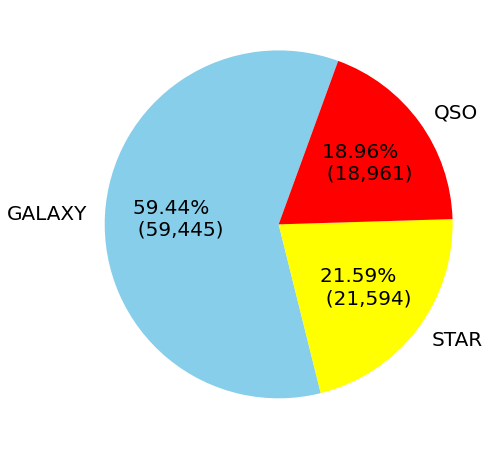

In [814]:
class_counts = df['class'].value_counts() #Calculates the number of objects in each class
index = class_counts.index #Give the unique names of the class
np.sum(class_counts)

#explode = (0.03,0.03,0.03)


plt.figure(figsize = (12, 8))
plt.pie(class_counts, autopct=lambda p : '{:.2f}% \n  ({:,.0f})'.format(p,p * sum(class_counts)/100),labels=index,colors=['skyblue','yellow','red'],textprops = {'fontsize': 20},startangle=70)

In [815]:
drop_columns = ['obj_ID', 'RA', 'DEC','run_ID', 'rerun_ID',
       'cam_col', 'field_ID', 'spec_obj_ID','plate',
       'MJD', 'fiber_ID']
data = df.drop(drop_columns,axis=1)
data

,u,g,r,i,z,class,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123
...,...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000
99996,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895
99997,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366
99998,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040


In [816]:
#Numericall represent the class since it is in string format
LE = LabelEncoder()
data['class'] = LE.fit_transform(data['class'])
data['class'].value_counts()

0    59445
2    21594
1    18961
Name: class, dtype: int64

In [817]:
X,y = data.drop(['class'],axis=1),df['class']
X

,u,g,r,i,z,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123
...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000
99996,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895
99997,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366
99998,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040


In [818]:
#To balance the data
sm = SMOTE(random_state = 30, k_neighbors = 5) 
under = RandomUnderSampler(random_state = 30)
a = ADASYN(random_state = 30)

#steps = [('u', under), ('o', sm)]
#pipeline = Pipeline(steps=steps)
#X, y = pipeline.fit_resample(X, y)

X, y = sm.fit_resample(X, y)
y.value_counts()

QSO       59445
GALAXY    59445
STAR      59445
Name: class, dtype: int64

In [819]:
y

0         GALAXY
1         GALAXY
2         GALAXY
3         GALAXY
4         GALAXY
           ...  
178330      STAR
178331      STAR
178332      STAR
178333      STAR
178334      STAR
Name: class, Length: 178335, dtype: object

In [820]:
y = LE.fit_transform(y)
y

array([0, 0, 0, ..., 2, 2, 2])

In [821]:
len(y), 59445 * 3

(178335, 178335)

In [822]:
X = X.to_numpy()
X

array([[ 2.38788200e+01,  2.22753000e+01,  2.03950100e+01,
         1.91657300e+01,  1.87937100e+01,  6.34793600e-01],
       [ 2.47775900e+01,  2.28318800e+01,  2.25844400e+01,
         2.11681200e+01,  2.16142700e+01,  7.79136000e-01],
       [ 2.52630700e+01,  2.26638900e+01,  2.06097600e+01,
         1.93485700e+01,  1.89482700e+01,  6.44194500e-01],
       ...,
       [ 1.91636082e+01,  1.80769068e+01,  1.77241965e+01,
         1.75915636e+01,  1.75633984e+01, -1.97375808e-04],
       [ 1.82810542e+01,  1.70650984e+01,  1.71402907e+01,
         1.72188201e+01,  1.72700463e+01, -3.45885162e-04],
       [ 2.09795397e+01,  1.98078344e+01,  1.95561866e+01,
         1.95317296e+01,  1.94274729e+01, -4.93619382e-04]])

In [823]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X, X.shape

(array([[ 8.50056224e-02,  7.25852847e-02,  3.70061033e-01,
         -6.31905909e-02, -5.29060847e-03, -8.63183814e-02],
        [ 1.19686213e-01,  9.40784144e-02,  1.57213117e+00,
          1.06750815e+00,  1.03696411e-01,  7.18908717e-02],
        [ 1.38419297e-01,  8.75912412e-02,  4.87965949e-01,
          4.00545104e-02,  6.81621783e-04, -7.60143448e-02],
        ...,
        [-9.69389581e-02, -8.95416506e-02, -1.09630473e+00,
         -9.52082332e-01, -5.28301022e-02, -7.82312407e-01],
        [-1.30993828e-01, -1.28614075e-01, -1.41688849e+00,
         -1.16256113e+00, -6.41652883e-02, -7.82475184e-01],
        [-2.68681081e-02, -2.26994156e-02, -9.04810145e-02,
          1.43480093e-01,  1.91981203e-02, -7.82637110e-01]]),
 (178335, 6))

In [824]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [825]:
y_train


tensor([0, 0, 2,  ..., 1, 2, 1])

In [826]:
X.shape[1]

6

In [827]:
h = np.linspace(5,100,20)
h


array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])


Number of Neurons: 20
Epoch [0/800], Loss: 1.1323
Epoch [10/800], Loss: 0.8637
Epoch [20/800], Loss: 0.6783
Epoch [30/800], Loss: 0.3749
Epoch [40/800], Loss: 0.3670
Epoch [50/800], Loss: 0.2866
Epoch [60/800], Loss: 0.3140
Epoch [70/800], Loss: 0.2825
Epoch [80/800], Loss: 0.2784
Epoch [90/800], Loss: 0.1974
Epoch [100/800], Loss: 0.2043
Epoch [110/800], Loss: 0.2957
Epoch [120/800], Loss: 0.4582
Epoch [130/800], Loss: 0.2206
Epoch [140/800], Loss: 0.3091
Epoch [150/800], Loss: 0.2836
Epoch [160/800], Loss: 0.3042
Epoch [170/800], Loss: 0.4299
Epoch [180/800], Loss: 0.2189
Epoch [190/800], Loss: 0.2046
Epoch [200/800], Loss: 0.1902
Epoch [210/800], Loss: 0.2041
Epoch [220/800], Loss: 0.5417
Epoch [230/800], Loss: 0.2625
Epoch [240/800], Loss: 0.2565
Epoch [250/800], Loss: 0.2127
Epoch [260/800], Loss: 0.1966
Epoch [270/800], Loss: 0.1970
Epoch [280/800], Loss: 0.2074
Epoch [290/800], Loss: 0.1814
Epoch [300/800], Loss: 0.1825
Epoch [310/800], Loss: 0.1459
Epoch [320/800], Loss: 0.145

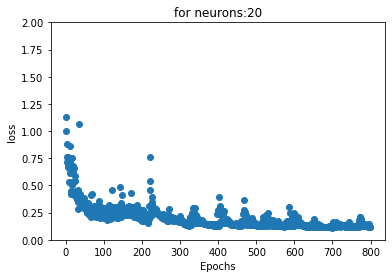

In [828]:
for i in [20]:
    print()
    print(f"Number of Neurons: {i}")
    neurons = int(i)
    
    class BNN(nn.Module):
        def __init__(self):
            super(BNN, self).__init__()
            self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=X.shape[1], out_features=neurons)
            self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=neurons)
            self.fc3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=neurons, out_features=3)
    
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x
        
        
    model = BNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    kl_weight = 0.001  # KL divergence weight for Bayesian layers
    
    losses=[]
    epochs = 800

    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train) 
        kl_loss = bnn.functional.bayesian_kl_loss(model.fc1) + bnn.functional.bayesian_kl_loss(model.fc2) + bnn.functional.bayesian_kl_loss(model.fc3)
    
        total_loss = loss + kl_weight * kl_loss
    
        losses.append(loss.detach().numpy())
    
    
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')
            
            
    plt.scatter(range(epochs),np.asarray(losses))
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.title(f"for neurons:{i}")
    plt.ylim(0,2)
    plt.show()

In [829]:
"""

with a kl_weight of 0.01 and a lr = 0.1, using neurons from 10 to 100, the loss did not go below 0.7.

with a kl_weight of 0.001 and a lr = 0.1 using 30 neurons, the loss went to 0.46, leading to 82% +/- 1.3% accuracy


Adding the redshift improved the model significantly to around 96% +/- 0.09%, for kl_wight 0.001 and 30 neurons

Adding more than 40 neurons decreases the accuracy



"""

'\n\nwith a kl_weight of 0.01 and a lr = 0.1, using neurons from 10 to 100, the loss did not go below 0.7.\n\nwith a kl_weight of 0.001 and a lr = 0.1 using 30 neurons, the loss went to 0.46, leading to 82% +/- 1.3% accuracy\n\n\nAdding the redshift improved the model significantly to around 96% +/- 0.09%, for kl_wight 0.001 and 30 neurons\n\nAdding more than 40 neurons decreases the accuracy\n\n\n\n'

In [830]:
model.eval()
with torch.no_grad():
    num_samples = 500
    y_pred_samples = []
    
    for _ in range(num_samples):
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_pred_samples.append(predicted)
        
    y_pred_samples = torch.stack(y_pred_samples).numpy()
    
    accuracies = [accuracy_score(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)]
    mean_accuracy = np.mean(accuracies)
    uncertainty_accuracy = np.std(accuracies)
    
    mean_confusion_matrix = np.mean([confusion_matrix(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)], axis=0)
    uncertainty_confusion_matrix = np.std([confusion_matrix(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)], axis=0)

    
print()  
print(f"Mean Accuracy: {mean_accuracy*100:.2f}%")
print(f"Accuracy Uncertainty: {uncertainty_accuracy*100:.2f}%")


Mean Accuracy: 95.32%
Accuracy Uncertainty: 0.69%


In [832]:
#Unbalanced data
#kl_weight: 0.1 -87.72% +/- 3.42; loss min = 0.33 
#kl_weight:.01 - 92.23% +/- 0.67%; loss min = 0.16
#kl_weight: 0.001 - 96.25% +/- 0.14%; loss min = 0.11

#Balenced data (undersampling)
#kl_weight:.01 - 94.61% +/- 0.32%; loss min = 0.17
#kl_weigth:0.001 - 96.72% +/- 0.13%

#Balenced data (oversample - SMOTE)
#kl_weight: 0.01 - 93.91% +/- 0.52%
#kl_weight: 0.001 - 95.32% +/- 0.69%

#Balenced data (oversample - ADASYN)
#kl_weight:.01 - 86.33% +/- 0.98%
#kl_weigth:0.001 - 89.11% +/- 0.14
#ADASYN may not be that good

In [ ]:
"""
keeping a kl_weight as low as 0.001 improved the accuracy to ~96%; however I think we should focus more on generalization 
since we will be testing a completely new data set and accept some loss in accuracy to maintain generalization

There is an very good improvement in the accuracy when I added the redshift section into the input data as well, and
when the Stardize the input values using StandardScalar

"""